# Programming for Chemists: Physical Chemistry using NumPy, SciPy and SymPy

**Importance for scientists:**
* This session is more mathematical than the previous ones, but crucially we are going to learn a variety of tools applicable in many different scientific applications, including:
    * Symbolic computation.
    * Finding maxima of functions.
    * Automatically varying fitting parameters to minimize or maximize certain values.
    * Random number generation.
    * Use matplotlib to produce animations, excellent for presentations.

This hands on session will explore two worked examples in intricate detail, adding more tools to your programming toolbox. First we discuss another useful Python library called [SymPy](https://www.sympy.org/en/index.html). SymPy is a Python library for symbolic mathematics; aiming to become a full-featured **computer algebra system (CAS)**. 

## Computer Algebra in SymPy 

Computer algebra refers to software packages that are capable of doing **symbolic mathematical computations** such as:

\\[
    (x + 1)^2 \hspace{0.5cm} \rightarrow \hspace{0.5cm} x^2 + 2x + 1,
\\]
where the word "algebraic" refers to operations with symbolic objects originating from algebra. Two well known software packages allowing for this functionality are *Maple* and *Mathematica*, but Python has a library called **SymPy** which provides us the ability to do symbolic computation in Python. Scientific computing is usually based on **numerical** computation using **approximate floating point numbers**, while symbolic computation emphasises **exact** computation with expressions containing variables that have no given value and are manipulated as symbols. 


| Pros                                 | Cons                                                               |
|:-------------------------------------|:-------------------------------------------------------------------|
| Exact Arithmetic                     | **Much slower** than numerical computation                         |
| Non-linear expressions with symbols  | Poor hardware support                                              |
| Inequalities, differential equations | Difficult to parallelize                                           |
| Results can be formulae              | Numerical problems better handled with "orthodox" computer methods |
| It "knows" how to integrate          | Number of expressions can grow exponentially                       |

### Example: Analytical vs. Numerical Integration

Consider the [known integral](https://functions.wolfram.com/Constants/Pi/07/01/01/0002/)

\\[
    4\int\limits_{0}^{1}\sqrt{1-t^2}\text{d}t = \pi.
\\]

We pass this integral to SymPy and it produces \\(\pi\\) **exactly**, not a floating point representation (we will discuss SymPy terminology throughout this tutorial):

In [1]:
import sympy as sy

# define t as symbol not requiring an explicit value
t = sy.symbols('t')

# define the integrand
integrand = sy.sqrt(1 - t**2)

# calculate the integral
4*sy.integrate(integrand, (t, 0, 1))

pi

Native programming languages; Python, C++, Fortran, Java etc... **cannot do this** without the help of customised libraries, but can solve the integral **approximately** using **numerical** methods. I programmed the following animation using matplotlib simulating a numerical technique called a **Riemann sum** of the same integral above; approximating the area under the function using an increasing number of rectangles:

<center><img src="https://raw.githubusercontent.com/adambaskerville/ProgrammingForChemists/master/images/riemann_sum.gif" width="900" height="900" /></center>

The field of numerical integration has developed faster, more sophisticated techniques to numerically calculate integrals over any number of dimensions which we will not discuss here; the Riemann sum was just used to emphasise a point.

## Solving the Hydrogen Atom 

This is a detailed investigation on how to solve the hydrogen atom; the building block of a lot of computational and quantum chemical methods. It can be described using the **time independent, non-relativistic Schr&ouml;dinger equation**

\\[
 \hat{H}\psi = E\psi,
 \tag{1}
\\]

where: 
* \\(\hat{H} \\) is the Hamiltonian, the total energy operator.
* \\(\psi\\) is the wavefunction, containing all the key physical behaviour of the system.
* \\(E\\) is the energy eigenvalue. 

This is the textbook system studied in quantum mechanics as it is one of the most simple, consisting of a single proton and electron. The radial part of the hydrogen atom is **exactly solvable** using a series solution method but lets pretend we are unaware of this and explore how a computer can solve it. The aim will be to get the computer to do *everything*, requiring no preliminary mathematics by us humans. We are going to use a very powerful mathematical technique called the **variational method**; using a combination of symbolic mathematics from **SymPy** and numerical techniques from **SciPy**. 

### Variational Method 

Consider the wave equation given in equation (1). If we multiply both sides by \\(\psi\\) and integrate over all space we end up with the following

\\[
E = \frac{\int \psi \hat{H}\psi \text{d}\tau}{\int \psi^2 \text{d}\tau}.
\tag{2}
\\]

When \\(\psi\\) is complex this becomes

\\[
E = \frac{\int \psi^* \hat{H} \psi \text{d}\tau}{\int \psi^* \psi \text{d}\tau}.
\tag{3}
\\]

We can now calculate the energy, \\(E\\) if we know the wavefunction, \\(\psi\\). If we do not know the exact wavefunction our best bet is to have an educated guess using some physical intuition; unlikely to be the exact wavefunction, but by labelling it as \\(\psi_1\\) it will calculate a value of the energy, \\(E_1\\). 

We can now guess a second wavefunction, \\(\psi_2\\), resulting in an energy value \\(E_2\\) and if desired we could guess even more wavefunctions, there is no limit. The variational principle tells us that if \\(E_g\\) is the exact ground state energy then both \\(E_1\\) and \\(E_2\\) will always be greater than \\(E_g\\) unless we somehow guess the exact wavefunction; which would then be equal to \\(E_g\\). We can represent the variational principle via the following inequality\\(^{[2]}\\)

\\[
\frac{\int\psi^* \hat{H} \psi \text{d}\tau}{\int \psi^* \psi \text{d}\tau} \ge E_g.
\tag{4}
\\]


Due to the inability of solving many-body problems exactly, computational and quantum chemistry is built upon approximate methods and a number of methods utilize the variational principle, including **Hartree Fock theory**. These work by making repeated iterative changes to the trial wavefunctions or density matrices, calculating the energy as they go until the lowest value has been found; safe in the knowledge it can not drop below the exact ground state solution. 

### Gaussian Wavefunction

For our first trial wavefunction, \\(\psi_1\\), we will use a single [Gaussian function](https://mathworld.wolfram.com/GaussianFunction.html). <font color='red'>Can you plot the function using matplotlib?</font>

\\[
\psi_1 = e^{-cr^2},
\\]

where \\(r\\) is the nucleus-electron distance and \\(c\\) is a **variational parameter** which our program will change throughout the calculation in order to find the lowest energy, \\(E_g\\). The Hamiltonian for the hydrogen atom is given by\\(^{[1]}\\)

\\[
\hat{H} = -\overbrace{\frac{\hbar^2}{2\mu}\nabla^2}^{K.E} - \overbrace{\frac{e^2}{r}}^{P.E},
\tag{5}
\\]

where \\(\mu\\) represents the reduced mass of the proton-electron pair (\\(\mu \approx 1\\) for the hydrogen atom). The Laplacian operator for the spherically symmetric 1s state of the hydrogen atom is

\\[
    \nabla^2 = \frac{\partial^2}{\partial r^2} + \frac{2}{r}\frac{\partial}{\partial r}.
\\]

To simplify the situation we can introduce a more natural set of units called **atomic units** which set the following constant values:

* Reduced planck constant: \\(\hbar = 1\\)
* Elementary charge: \\(e = 1\\)
* Bohr radius: \\(a_0 = 1\\)
* Electron mass: \\(m_e = 1\\)

These units simplify the Hamiltonian

\\[
\hat{H} = -\overbrace{\frac{1}{2}\nabla^2}^{K.E} - \overbrace{\frac{1}{r}}^{P.E}.
\tag{6}
\\]

The first thing we do is import NumPy, SciPy, SymPy and a useful module within the SciPy library called `Optimize` containing a lot of functionality relevant for non-linear optimization problems. We want to import the `minimize` function which we do using

`from scipy.optimize import minimize`

As we are going to solve this symbolically using computer algebra we need to tell Python to treat the coordinate `r` as a symbol not requiring an explicit value. We do this using `sy.symbols('r')` from SymPy:

`r = sy.symbols('r')`

which tells the program to treat `r` as a generic variable not needing an explicit value.

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy

# import minimize function from optimize

# tell Python to treat r as a symbol, not a numerical value


We need to keep changing the value of the variational parameter, \\(c\\), so need a Python object which can continually take unique input and return unique output -> **Function**. 

Further down this worksheet you will see a function called `min_energy(c):` with a placeholder docstring and multiple lines with missing code. We are going to discuss all the quantities needed to solve the problem, and your task is to fill in the blanks in the program. If you get stuck you can ask me, or I have included a complete working example of the program at the end of this worksheet for you to compare yours against.

Lets begin working through what is needed to minimize the energy of the hydrogen atom.

**Define wavefunction:**

The first step is to tell the program what our Gaussian wavefunction looks like:

`psi_1 = sy.exp(-c*r**2)`

where we have called the SymPy implementation of the exponential function. 

**Define Hamiltonian:**

We next define the Hamiltonian operator and get SymPy to evaluate the differential operators for us, symbolically! Remember an operator, our Hamiltonian, only makes sense if it **is acting on something** so we will act it on the wavefunction on its right hand side of equation (4):

`hamiltonian = (-1/2)*(sy.diff(psi_1, r, r) + (2/r)*sy.diff(psi_1, r)) - (1/r)*psi_1`

There is a lot to unpack here so lets break it down:

1. `sy.diff` calls the differential operator from SymPy. The first differential in our \\(\nabla^2\\) operator is a second order derivative with respect to \\(r\\) which can be programmed in two equivalent ways:

    `sy.diff(psi_1, r, r)` or `sy.diff(psi_1, r, 2)`

2. the next derivative is first order:

    `sy.diff(psi_1, r)`

3. we also need to multiply the potential energy term at the end by `psi_1` as it is part of the Hamiltonian operator.

**Volume element:**

Next we need to consider **Heisenberg's uncertainty principle**, relating to how the electron will not idly sit at a fixed position from the proton; but instead have a finite probability of existing at any position in the sphere traced out by "swinging" the radius joining the proton and electron around. The surface area of a sphere is \\(4\pi r^2\\) which we will program as our volume element, `dv`, remember to use `sy.pi`.

**Integration:**

We have now defined our wavefunction, Hamiltonian operator and volume element, so we can now conduct the integration. We will implement two expressions, one for the numerator (`num`) of equation (4) and one for the denominator (`den`):

`num = sy.N(sy.integrate(psi_1*hamiltonian*dv, (r, 0, sy.oo)))`

Lets break this down:

1. To symbolically integrate in SymPy we call:

    `sy.integrate(integrand, (variable to integrate over, start, end))` 

2. We want to integrate over \\(r\\) from 0 to \\(\infty\\) as quantum mechanics tells us the electron can technically reside in a sphere stretching out to the edge of the Universe, even though the probability is effectively zero past a radius of several Bohr radii.

    `(r, 0, sy.oo)`

    infinity is represented as `oo` in Sympy. The denominator can be programmed using an almost identical syntax, *have a go yourself*. 

3. As SymPy evaluates it symbolically, it will leave it in a general form (print out the result to check for yourself!) and we want a numeric answer so call `sy.N` which numerically evaluates the expressions for us.

We then calculate the energy by dividing: `E = num/den`. A useful feature of an optimisation program is to output each step of the optimisation process so the user can see what is happening. We can print out the value of `c` and `E` each time the function is called:

`print("c = {:.6f}, Energy = {:.10f}".format(c, E))`

We are finished! <font color='red'>You can fill in the following function using what we just discussed</font>. Outside the function we set the initial value of `c=3` and then call the minimize function from SciPy which varies the value of `c` until it has achieved a convergence tolerance of \\(1 \times 10^{-6}\\), `tol=1e-6`, or 6 decimal places:

In [ ]:
def min_energy(c):
    '''
    This function minimises the energy with respect to a single variational parameter c
    
    Parameters:
    -----------
    c : 
        
    
    Returns:
    --------
    E : 
        

    '''
    # The scipy minimize function passes the parameters in an array. 
    # To use it within our mathematical formulae we need to extract it as a separate number, done using the index [0]
    c = c[0]
    
    # define the Gaussian wavefunction

    # define the Hamiltonian

    # define the volume of integration

    # define the numerator of the variational principle

    # define the denominator of the variational principle

    # calculate the energy
    E = num/den

    # print the current value of c and E 
    
    # return E to the minimize function
    return E

# set an initial value for the variational parameter 'c'
c = 3

# call the minimize function, tell it the parameter to vary, c, and tell it the tolerance for convergence, tol
hydrogen_gs = minimize(min_energy, c, tol=1e-6)

# print the final result to terminal
print(hydrogen_gs)

We have a final energy of \\(E_g = -0.4244131816\\) hartrees when \\(c = 0.28294212\\). This is not too bad, but we know the exact ground state energy for a one-electron system

\\[
E_g = -\frac{Z^2}{2},
\\]

where \\(Z\\) is the nuclear charge, so for the hydrogen atom \\(E = -0.5\\) hartrees. Using a Gaussian wavefunction produces an Energy value with a \\(\approx 15\%\\) error!

### Slater-type orbital Wavefunction

Let us consider a better approximation for our wavefunction, this time using a **Slater-type orbital**:

\\[
\psi_2 = e^{-cr}.
\\]

Why is this better? Lets plot the Slater-type function against the Gaussian function using matplotlib:

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

# create the figure (fig) and axes (ax) objects
fig, ax = plt.subplots()

# create r range from 0 -> 5 with a step of 0.05
r = np.arange(0, 5, 0.05)   # start, stop, step

# define gaussian function
gaussian = np.exp(-r**2)

# define slater function
slater = np.exp(-r)

# set the range of the x-axis data
ax.set_xlim([0, 5])

# set the range of the y-axis data
ax.set_ylim([0, 1])

# set the axis labels
ax.set_xlabel('r')
ax.set_ylabel(r'$\psi$')

# call the plot command
ax.plot(r, gaussian, label = 'Gaussian')
ax.plot(r, slater, label = 'Slater')

# plot the legend
ax.legend()

plt.show()

These two forms look quite different, and the key reason why the Slater form is more **physically realistic** than the Gaussian form is that it reaches a **cusp** at the origin, \\(r=0\\), which is a rule particles have to obey when they coalesce; [rigorously proven](https://onlinelibrary.wiley.com/doi/abs/10.1002/cpa.3160100201) by Tosio Kato in 1957. Change the scale(s) of the plot to get a closer look. 

Return to your program, or the complete version at the bottom of the script, and change the Gaussian function for a Slater-type function and see what the new result is.

We end up with \\(E_g = -0.5\\) hartrees when \\(c=1\\), matching the exact energy to the specified precision. This also reveals the nature of the exact wavefunction of the hydrogen atom but also any one-electron system

\\[
\psi = e^{-Zr},
\\]

where \\(Z\\) is the nuclear charge. Lets plot wavefunctions for various \\(Z\\)-values using a `for` loop:

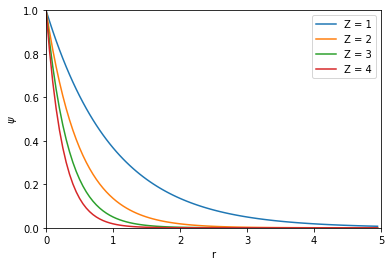

In [11]:
from matplotlib import pyplot as plt
import numpy as np

# create the figure (fig) and axes (ax) objects
fig, ax = plt.subplots()

# create r range from 0 -> 5 with a step of 0.05
r = np.arange(0, 5, 0.05)   # start, stop, step

# set the range of the x-axis data
ax.set_xlim([0, 5])

# set the range of the y-axis data
ax.set_ylim([0, 1])

# set the axis labels
ax.set_xlabel('r')
ax.set_ylabel(r'$\psi$')

for Z in range(1,5):
    # define slater function
    slater = np.exp(-Z*r)
    
    # call the plot command
    ax.plot(r, slater, label = "Z = {}".format(Z))

    # plot the legend
    ax.legend()

plt.show()

### Radial Distribution Functions
We now have our optimised Gaussian and Slater type wavefunctions

**Gaussian:**

\\[
\psi_1 = e^{-0.28294212 r}
\\]

**Slater:**

\\[
\psi_2 = e^{-1r}
\\]

We can use these wavefunctions to calculate the **radial Distribution Function (RDF)** of the hydrogen atom; i.e. the electron density around the proton

\\[
    \text{RDF} = 4\pi r^2\psi\psi|_{r=r'}
    \tag{7}
\\]

where we fix the coordinate \\(r\\) to be values in the range \\(0 \le r' \le \infty\\). 

**Normalisation:**

We need to make sure the RDF is normalised correctly otherwise it will not reflect the true physical nature of the system. We want the area under the RDF curves to equal 1 representing 100%; i.e. there is a 100% chance the electron is located somewhere in space, which is physically true. We can calculate the normalisation of our wavefunctions using

\\[
    \text{Norm} = \langle \psi|\psi \rangle = \int\limits_{0}^{\infty}\psi\psi\text{d}\tau,
    \tag{8}
\\]
which we need only calculate **once** using SymPy, and then divide the RDF function by the normalisation value achieving normalisation:

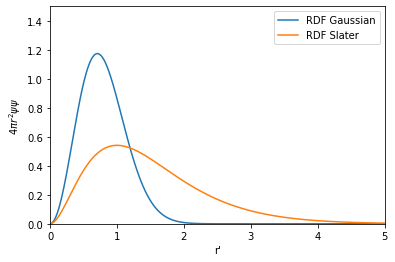

In [12]:
from matplotlib import pyplot as plt
import numpy as np
import sympy as sy
from sympy import lambdify

r = sy.symbols('r')

# create the figure (fig) and axes (ax) objects
fig, ax = plt.subplots()

# define gaussian function
gaussian = sy.exp(-r**2)

# define slater function
slater = sy.exp(-r)

# define volume element
dv = 4*sy.pi*r**2

# calculate the inner product <psi|psi> of the gaussian wavefunction
gaussian_norm = sy.N(sy.integrate(gaussian*gaussian*dv, (r, 0, sy.oo)))

# calculate the inner product <psi|psi> of the slater-type orbital wavefunction
slater_norm = sy.N(sy.integrate(slater*slater*dv, (r, 0, sy.oo)))

# calculate the RDF using the Gaussian wavefunction
RDF_gaussian = gaussian*gaussian*dv / gaussian_norm
lam_gaussian = lambdify(r, RDF_gaussian)

# calculate the RDF using the slater-type orbital wavefunction
RDF_slater =  slater*slater*dv / slater_norm
lam_slater = lambdify(r, RDF_slater)

# set the range of the x-axis data
ax.set_xlim([0, 5])

# set the range of the y-axis data
ax.set_ylim([0, 1.5])

# set the axis labels
ax.set_xlabel("r'")
ax.set_ylabel(r'$4\pi r^2\psi\psi$') # This notation uses LaTeX math font!

# generate 500 r' values (rp) between 0 and 5
rp_vals = np.linspace(0, 5, 500)  # start, stop, no. points 

# calculate the y-values of the graph using the RDF functions
y_vals_gaussian = lam_gaussian(rp_vals)
y_vals_slater   = lam_slater(rp_vals)

# call the plot command
ax.plot(rp_vals, y_vals_gaussian, label = 'RDF Gaussian')
ax.plot(rp_vals, y_vals_slater, label = 'RDF Slater')

# plot the legend
ax.legend()

plt.show()

Check they are normalised by integrating the RDF functions to calculate the area underneath the curves; <font color='red'>write the code for the slater-type orbital wavefunction</font>:

In [ ]:
# check normalisation of the RDF using a gaussian wave function
print(sy.N(sy.integrate(RDF_gaussian, (r, 0, sy.oo))))

# check normalisation of the RDF using a gaussian wave function


### Most Probable Value of r

If we look at the RDF plots above, they are not symmetric about a point like a standard Gaussian function is; meaning the **most probable** and **average** value of \\(r\\) are not equal! the most probable value is given by the position of the maximum of the curve. To find and classify extreme points of a function take the first derivative and set equal to 0 and solve. As we know the function has a maximum by visual inspection we do not need to take the second derivative in order to classify whether it is a maximum, minimum or point of inspection, <font color='red'>but try adding this to the following function, perhaps include `if` statements to print out what type of extreme point it is</font>:

In [16]:
def find_extremes(func, arg):
    '''
    This function find the extreme points of a sympy function, returning the maximum value
    
    Parameters:
    -----------
    func : sympy.core.mul.Mul
           This is the symbolic sympy expression which we want to find the maximum of
        
    arg : sympy.core.symbol.Symbol
          This is the variable to differentiate wirht respect to.
    
    Returns:
    --------
    max(extremes) : The maximum value in the extreme points list
    '''
    # calculate first derivative
    dy = sy.diff(func, arg)
    
    # calculate extreme points
    extremes = sy.solve(dy, arg)

    return max(extremes)

print("Most probable r for Gaussian = {:.3f}".format(find_extremes(RDF_gaussian, r)))

print("Most probable r for Slater = {:.3f}".format(find_extremes(RDF_slater, r)))

Most probable r for Gaussian = 0.707
Most probable r for Slater = 1.000


The most probable value of \\(r\\) for hydrogen is exactly \\(r = 1\\) a.u. so this shows that the Gaussian wavefunction does not just underestimate the ground state energy, but also the physical properties of the system.

### Expectation Value of \\(r\\)

Expectation values represent the average value of a given quantity, which in the case of the proton-electron distance, \\(r\\), in the hydrogen atom is

\\[
    \langle \psi| r |\psi \rangle = \frac{\int\limits_{0}^{\infty} \psi r \psi \text{d}\tau}{\int\limits_{0}^{\infty}\psi\psi\text{d}\tau}
    \tag{9}
\\]

<font color='red'>The following code calculates this in SymPy. but there are several typographic errors. Follow the errors to fix the issues and then run the code</font>:

In [ ]:
# gaussian expectation value of r
expec_num_gaussian = sy.N(sy.integrate(gaussian*r*gaussian*dv, (r, 0, sy.oo)))
expec_den_gaussian = sy.N(sy.integrate(gaussian**gaussian*dv, (r, 0, sy.OO)))

print("<r> using Gaussian = {:.4f}".format(expec_num_gaussian / expec_den_gaussian))

# slater-type expectation value of r
expec_num_slater = sy.N(sy.int(slater*r*slater*dv, (r, 0, sy.oo)))
expec_den_slater = sy.N(sy.integrate(slater*slater*dv, (, 0, sy.oo)))

print("<r> using Slater = {:.4f}".format(expec_num_slater / expec_den_slater))

## Complete Hydrogen Atom Program

In [ ]:
import numpy as np
import scipy as sp
import sympy as sy
from scipy.optimize import minimize

r = sy.symbols('r')

def min_energy(c):
    '''
    This function minimises the energy with respect to a single variational parameter c
    
    Parameters:
    -----------
    c : np.ndarray
        This is the current value of the c parameter
    
    Returns:
    --------
    E : sympy.core.numbers.Float
        This number represents the energy value in hartrees

    '''
    # The scipy minimize function passes the parameters in an array. 
    # To use it within our mathematical formulae we need to extract it as a separate number, done using the index [0]
    c = c[0]

    # define the Gaussian wavefunction
    psi = sy.exp(-c*r**2)

    # define the Hamiltonian
    hamiltonian = (-1/2)*(sy.diff(psi, r, r) + (2/r)*sy.diff(psi, r)) - (1/r)*psi

    # define the volume of integration
    dv = 4*sy.pi*r**2

    # define the numerator of the variational principle
    num = sy.N(sy.integrate(psi*hamiltonian*dv, (r, 0, sy.oo)))

    # define the denominator of the variational principle
    den = sy.N(sy.integrate(psi*psi*dv, (r, 0, sy.oo)))

    # calculate the energy
    E = num/den

    # print the current value of c and E 
    #print("c = {:.6f}, Energy = {:.10f}".format(c, E))

    # return E to the minimize function
    return E

# set an initial value for the variational parameter 'c'
c = 3
bnds = ((0,10),)
# call the minimize function, tell it the parameter to vary, c, and tell it the tolerance for convergence
hydrogen_gs = minimize(min_energy, c, tol=1e-6, bounds=bnds)

print(hydrogen_gs)

# Brownian Motion Simulation

Brownian motion named after its discoverer, botanist Robert Brown, is the motion exhibited by a small particle totally immersed in a liquid or gas. It is an example of a **stochastic process**, referring to a family of random variables indexed against some other variable or set of variables. Stochastic processes are used as mathematical models of systems appearing to vary in a random manner such as growth of a bacterial population, decay of radioactive elements or the movement of a gas molecule; with Brownian motion being one of the most useful stochastic processes in applied probability theory. **We are going to simulate a gas molecule moving around a 3-dimensional box** using NumPy and matplotlib. First lets cover the maths required to model the random motion of our gas molecule, it ends up being much simpler than it looks!

## Mathematics

A stochastic process, \\(X(t)\\), is said to be a Brownian motion process if\\(^{[3]}\\):

* \\(X(0)=0\\) is certain, i,e, has probability 1. 
* \\(\lbrace X(t), t \ge 0\rbrace \\) has stationary and independant increments.
* For every \\(t>0\\), \\(X(t)\\) is normally distributed with mean, \\(\mu = 0\\) and variance \\(\sigma^2 = 1\\).

\\[
\begin{aligned}
    X(t_2) - X(t_1) &\approx \sqrt{t_2 - t_1}\mathcal{N}(\mu,\sigma^2) \\
          dX(t_i)   &\approx \sqrt{\Delta t}\mathcal{N}(0,1)
\end{aligned}
 \tag{10}
\\]
where \\(\mathcal{N}(\mu,\sigma^2)\\) denotes the normal distribution. In order to simulate this in Python, we need to start by discretizing our time interval \\([0,T]\\) into \\(N\\) time steps, \\(\Delta t\\):

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation # call the animation module of matplotlib
from IPython.display import HTML               # this is only required when running the code in the Jupyter notebook
import mpl_toolkits.mplot3d.axes3d as p3       # this imports the 3d axis option from matplotlib otherwise we only have access to 2d space! 

fig = plt.figure()
ax = p3.Axes3D(fig)

T = 1    # this is an arbitrary time unit
N = 1000 # number of steps
dt = T/N # the ratio gives the time step increment

Similar to before, we initiate the `figure` object using `plt.figure()` but this time we initialise the axis object as a 3d axis object using `p3.Axes3D(fig)` which tells matplotlib to accept and display \\(x, y, z\\) data to form a 3D plot.

As our as molecule is moving inside a **box** we need to know its \\(x\\), \\(y\\) and \\(z\\) coordinates in order to map its path as it moves through the box. Equation (10) shows us that this is just the product of the square root of the time interval, \\(\Delta t\\) and a random number from the standard normal distribution, \\(\mathcal{N}(0,1)\\). There is an inbuilt NumPy function to do just this called:

[`np.random.randn(d0,d1,...,dn)`](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.random.randn.html)

which generates a random number from the standard normal distribution with specified shape `d0,d1,...,dn`. Keep re-running the cell and you will see a new number output each time:

In [ ]:
# single random number from the standard normal distribution
print(np.random.randn(1))

# array of size 2,4 filled with random numbers from the standard normal distribution
print(np.random.randn(2, 4))

We will label the changes in each coordinate as `dX, dY, dZ` respectively, <font color='red'>don't forget to assign the dZ variable</font>:

In [ ]:
dX = np.sqrt(dt) * np.random.randn(1, N)
dY = np.sqrt(dt) * np.random.randn(1, N)


By using NumPy we have arrays which contain all the changes in coordinates for the entire simulation, no looping required! `dX, dY, dZ` represent the **changes** in position but not the position itself. In order to do this we need to cumulatively add each number in the array in order to represent the new position of the particle at each time step; achievable using a `for` loop but there is a function in NumPy designed for this exact purpose, [`np.cumsum()`](https://numpy.org/doc/stable/reference/generated/numpy.cumsum.html):

In [ ]:
# create a list of integers
lst = [1, 3, 5, 7, 9]

# call cumsum on the list to cumulatively add the elements
# 1 + 3 = 4   ->   4 + 5 = 9   ->   9 + 7 = 16   ->   16 + 9 = 25
np.cumsum(lst)

We can apply this function to our arrays resulting in a new array which contains the actual \\(x\\), \\(y\\) and \\(z\\) coordinates of our gas molecule

In [ ]:
X = np.cumsum(dX) # Cumulatively add to get the x positions of the particle
Y = np.cumsum(dY) # Cumulatively add to get the y positions of the particle
Z = np.cumsum(dZ) # Cumulatively add to get the z positions of the particle

We now have arrays that hold the coordinates of the gas molecule for the entire simulation; and now move onto how matplotlib  can animate the path taken by the molecule.

## Simulation

<font color='red'>We first create a `line` object</font> which sets the desired attributes, which in this case are that it’s coloured blue and has a line weight (thickness), `lw` of 1. Note the comma after line, required as the output of `ax.plot` is a tuple or list containing 1 item. The comma unpacks the value out of the list into a variable which the rest of the program can use: 

`line, = ax.plot(X, Y, Z, color='blue', lw=1)`

Matplotlib has a useful function called [`FuncAnimation()`](https://matplotlib.org/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation) which has the ability to create an animation by repeatedly calling a function which we will now define. This function requires a single argument which updates the line plot each step; the argument acting as a iterator to iterate through the coordinates in the arrays. Matplotlib handles 2D and 3D data seperately meaning we use `set_data` to declare the \\(x,y\\) data and set the third dimension, the 'depth' separately using `set_3d_properties()`:

In [ ]:
def animate(i):
    '''
    Fill in the docstring!
    '''
    line.set_data(X[:i], Y[:i])   # set the x,y data 
    line.set_3d_properties(Z[:i]) # the third dimension is treated separately in matplotlib and is set as the 3d property using .set_3d_properties

    return line # return the updated line object to the FuncAnimation function

Finally we call `FuncAnimation` which repeatedly calls our `animate()` function:

In [ ]:
anim = FuncAnimation(fig, animate, interval=10, frames=N, repeat=False)
# fig calls the figure object we created above so it can update the figure with each coordinate position of our molecule
# animate is the name of our function we defined above which FuncAnimation is going to loop through 
# interval sets the delay between frames in milliseconds
# frames represents the total number of frames to show, which we set to the total number of time steps
# repeat can be set to True|False if you want the animation to loop

If you are running this in the Jupyter notebook, then you will need to call a unique command which is not required if running locally. This is due to the way the web browser handles the animation and instead needs it to be processed as a html5 video tag. If running locally you only need to call `plt.draw()` followed by `plt.show()`:

In [ ]:
HTML(anim.to_html5_video()) # This is just for the Jupyter notebook which will not show the animation when using plt.show()

# if running locally, uncomment this line and remove the HTML command above.
#plt.show()

After a short delay you should see your gas molecule's trajectory as it moves around the box! <font color='red'>An interesting extension to this program is to add in more than 1 gas molecule; have a go and experiment!</font>

## Complete Brownian Motion Simulation Code

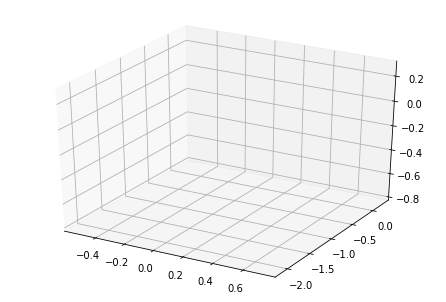

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import mpl_toolkits.mplot3d.axes3d as p3
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = p3.Axes3D(fig)

N = 2000 # Number of points
T = 1.0
dt = T/(N-1)

dX = np.sqrt(dt) * np.random.randn(1, N)
X = np.cumsum(dX) # Cumulatively add these values to get the x positions of the particle

dY = np.sqrt(dt) * np.random.randn(1, N) 
Y = np.cumsum(dY) # Cumulatively add these values to get the y positions of the particle

dZ = np.sqrt(dt) * np.random.randn(1, N) 
Z = np.cumsum(dZ) # Cumulatively add these values to get the z positions of the particle

line, = ax.plot(X, Y, Z, color='blue', lw=1)

def animate(i):
    '''
    This function is iterated over by FuncAnimation to produce the frames necessary to produce the animation 
    
    Parameters:
    -----------
    i : int
        This is the index used to iterate through the coordinate arrays
    
    Returns:
    --------
    line : mpl_toolkits.mplot3d.art3d.Line3D
           This contains the line information which is updated each time the function is iterated over
    '''
    line.set_data(X[:i], Y[:i])
    line.set_3d_properties(Z[:i])

    return line

anim = FuncAnimation(fig, animate, interval=10, frames=N, repeat=False)

HTML(anim.to_html5_video()) # This is just for the Jupyter notebook which will not show the animation when using plt.show()

# if running locally, uncomment these two lines and remove the HTML command above.
#plt.show()

# References

[1] Quantum Mechanics, F. Mandl, 1992, Wiley & Sons, page 56.

[2] Quantum Mechanics, F. Mandl, 1992, Wiley & Sons, page 187.

[3] Introduction to Probability Models 10th Edition, S. M. Ross, 2010, Elsevier, page 632.